In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import math
import numpy as np
import numpy.matlib
import pandas as pd
import networkx as nx        # for graphical model visualization
from scipy import linalg
from numpy.linalg import inv
import matplotlib.pyplot as plt

from ismember import ismember

## 1. [Modeling] Construction of a Bayesian Network Graphical Model:

- Assuming arbitrary parameters and a random network structure for each factor in the conditional probability distribution.
- Assuming random variables with different cardinalities.

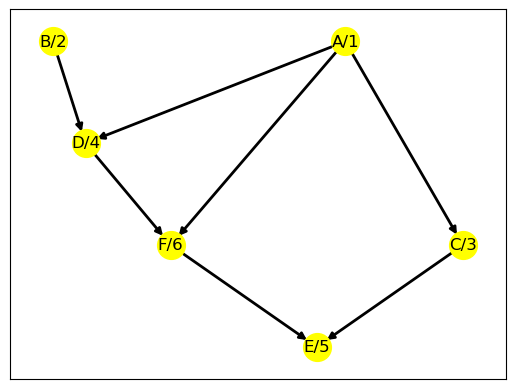

<Figure size 100x100 with 0 Axes>

In [3]:
let_to_num = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6}
randVar = ['A', 'B', 'C', 'D', 'E', 'F']
values  = [ 1,   2,   3,   4,   5,   6]

ltn = dict( zip(randVar, values) )

# graphical model construction
G = nx.DiGraph()
G.add_edges_from([('B/2', 'D/4')])
G.add_edges_from([('A/1', 'D/4')])
G.add_edges_from([('A/1', 'C/3')])
G.add_edges_from([('D/4', 'F/6')])
G.add_edges_from([('A/1', 'F/6')])
G.add_edges_from([('C/3', 'E/5')])
G.add_edges_from([('F/6', 'E/5')])

#pos = nx.spring_layout(G, seed=3) # positions for all nodes, seed for reproducibility
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")

# nodes
nx.draw_networkx_nodes(G, pos, node_color= 'yellow', node_size=400)

# edges
nx.draw_networkx_edges(G, pos, width=2)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=12)

# node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

plt.figure(figsize=(1, 1))
plt.show()

class Struct:
    def __init__(self, var=None, card=None, val=None):
        self.var = var
        self.card = card
        self.val = val

# input probab tables
probab_A = Struct([let_to_num['A']], [2], [0.4, 0.6])
probab_B = Struct([let_to_num['B']], [3], [0.3, 0.4, 0.3])
probab_C = Struct([let_to_num['C'], let_to_num['A']], [3, 2], [0.3, 0.25, 0.45, 0.05, 0.2, 0.75])
probab_D = Struct([let_to_num['D'], let_to_num['A'], let_to_num['B']], [2, 2, 3], [0.05, 0.95, 0.22, 0.78, 0.93, 0.07, 0.53, 0.47, 0.4, 0.59, 0.3, 0.7])
probab_E = Struct([let_to_num['E'], let_to_num['C'], let_to_num['F']], [2, 3, 2], [0.02, 0.98, 0.3, 0.7, 0.13, 0.87, 0.32, 0.68, 0.92, 0.08, 0.58, 0.42])
probab_F = Struct([let_to_num['F'], let_to_num['A'], let_to_num['D']], [2, 2, 2], [0.95, 0.05, 0.43, 0.57, 0.1, 0.9, 0.28, 0.72])
probab_tables = [probab_A, probab_B, probab_C, probab_D, probab_E, probab_F]

In [4]:
def IndexToAssignment(I, D):
    """
    I: list of indices to be converted.
    D: list of caradinalities.
    
    returns: np.array() of assignments.
    """
    D = np.array(D).reshape( (1, len(D)) ) # ensure D is a row vector
    I = np.array( I ).reshape( (len(I), 1) )
    
    den = np.matlib.repmat( np.cumprod( np.concatenate( (np.array([1]), D[0][:-1]) ) )  , I.shape[0], 1)
    num = np.matlib.repmat( I-1, 1,  D.shape[1])
    AA = np.floor( num / den )
    BB = np.matlib.repmat( D, len(I), 1 )
    result = np.mod( AA, BB ) + 1     # whether or not you want to add 1 is a modeling option, ofcourse.
    return np.array(result, dtype=int)
"""
# to check whether the function is working as expected or not.
D = [2, 2]
I = list( range(1, np.prod(D) + 1) )
A = IndexToAssignment(I, D)
print(A, AssignmentToIndex(A, D))
"""
def AssignmentToIndex(A, D):
    """
    A: np.array() of assignments 
    D: list of caradinalities.
    
    returns: np.array() of indices.
    """
    D = np.array(D).reshape( (1, len(D)) ) # ensure D is a row vector
    
    if 1 in A.shape:
        x = np.cumprod( np.concatenate( (np.array([1]), D[0][:-1]) ) )
        x = np.expand_dims(x, axis=0)
        I = np.dot( x, (A - 1).T) + 1
    else:
        I = np.sum( np.matlib.repmat( np.cumprod( np.concatenate( (np.array([1]), D[0][:-1]) ) ), A.shape[0], 1 ) * (A - 1) , axis=1) + 1
        
    return I

def product_factor(factor1, factor2):  
    """
    Computes the product of two factors (fundamental computation to solve many downstream tasks).
    
    input:  factor1: Struct 
            factor2: Struct
           
    output: factor3: Struct: another factor that computes their product.
    """
    # determining variables in the new factor.
    factor3 = Struct()
    factor3.var = sorted( list( set(factor1.var + factor2.var) ) ) # a sorted non-repeated union
    #print("factor3 variables: ", factor3.var)
    
    # determining the cardinality of the new factor.
    _, mapfactor1 = ismember(factor1.var, factor3.var)
    _, mapfactor2 = ismember(factor2.var, factor3.var)
    factor3.card = [0] * len(factor3.var)
    #print("mapfactor1: ", mapfactor1) # factor 1 me jo elements hai vo factor 3 mei kaha milengey?
    #print("mapfactor2: ", mapfactor2)
    
    for index, element in enumerate(mapfactor1):
        factor3.card[element] = factor1.card[index]
    for index, element in enumerate(mapfactor2):
        factor3.card[element] = factor2.card[index]
    
    # determining the probability values associated with the new factor.
    totalNumberofValues = math.prod(factor3.card)
    factor3.val = [-1] * totalNumberofValues
    assignments = IndexToAssignment( list( range(1, totalNumberofValues+1) ),  factor3.card ) 
    #print(assignments)
    
    indxfactor1 = AssignmentToIndex( assignments[:, mapfactor1], factor1.card ).ravel()  # acessing factor1.val elements
    indxfactor2 = AssignmentToIndex( assignments[:, mapfactor2], factor2.card ).ravel()  # acessing factor2.val elements
    #print(indxfactor1, indxfactor2)
    #print(indxfactor1.ravel(), indxfactor2.ravel())
    
    
    for index in range(totalNumberofValues):
        factor3.val[index] = factor1.val[ indxfactor1[index]-1 ] * factor2.val[ indxfactor2[index]-1 ]
        
    return factor3

def compute_joint_distribution(probab_tables):
    """
    Computes the joint distribution given a list of probability factors as input.
    
    input:   probab_tables: List of Struct's
    
    output:  joint:         Struct
    """
    joint = probab_tables[0]
    for index, probab_table in enumerate(probab_tables):
        if index >0:
            joint = product_factor(joint, probab_table)
            
    return joint

def sum_marginalization(factor1, variableOut):
    """
    Marginalizes out variables in variableOut from factor1.
    
    input:  factor1: Struct  
            variableOut: List: A list of variables to be marginalized out from factor1.var
            
    output: Struct
    """
    # determining variables in the new factor.
    factor3 = Struct()
    factor3.var = sorted( list( set(factor1.var) - set(variableOut) ) )
    
    # determining the cardinality of the new factor.
    mapfactor3 = []
    for randomVar in factor3.var:
        for index in range(len(factor1.var)):
            if factor1.var[index] == randomVar:
                mapfactor3.append(index)
                break
    factor3.card = [0] * len(factor3.var)
    
    for idx in range(len(factor3.card)):
        factor3.card[idx] = factor1.card[ mapfactor3[idx] ]
    
    # yeh pata karo ki factor3 me jo variables hai vo factor1 me kaha milengey.
    #_, mapfactor1 = ismember(factor1.var, factor3.var)
    #for idx in mapB:
    #    B.card.append(A.card[idx])
    
    totalNumberofValuesfactor1 = math.prod(factor1.card)
    assignments = IndexToAssignment( list( range(1, totalNumberofValuesfactor1+1) ), factor1.card )
    indxfactor3 = AssignmentToIndex( assignments[:, mapfactor3], factor3.card ).ravel()
   
    # determining the probability values associated with the new factor.
    totalNumberofValuesfactor3 = math.prod(factor3.card)
    factor3.val = [0] * totalNumberofValuesfactor3
    
    for i in range(1, totalNumberofValuesfactor3+1):
        for j in range(totalNumberofValuesfactor1):
            if indxfactor3[j]==i:
                factor3.val[i-1] = factor3.val[i-1] + factor1.val[j]
                
    return factor3

def observe_evidence(probab_tables, evidence):
    """
    Incorporates evidence in the 
    
    input:  probab_tables: List of Struct's
            evidence:      np.array([])
    
    output: probab_tables: List of Struct's: the function modifies the input factor to incorporate evidence.
    
    """
    if evidence.size!=0:
        for rowIndex, element in enumerate(evidence):
            #print(rowIndex, element)
            variable = element[0] # which RV is evidence?
            value    = element[1] # the value it takes?
            #print(variable, value)

            for probab_table in probab_tables:

                if variable in probab_table.var:
                    totalNumberofValues = math.prod(probab_table.card)
                    assignments = IndexToAssignment( list( range(1, totalNumberofValues+1) ),  probab_table.card )
                    #print(assignments)
                    for ii, rowAssignment in enumerate(assignments):
                        for jj, randVar in enumerate(probab_table.var):
                            if randVar==variable:
                                if assignments[ii, jj]!=value:
                                    length = assignments[ii, :].shape[0]
                                    #print( assignments[ii, :].reshape( (1, length)).shape )
                                    #print(assignments[ii, :], probab_table.card)
                                    index_to_be_assigned = AssignmentToIndex(assignments[ii, :].reshape( (1, length) ), probab_table.card)
                                    index_to_be_assigned = index_to_be_assigned.item()
                                    #print(index_to_be_assigned)
                                    probab_table.val[ index_to_be_assigned-1 ] = 0
                       
    return probab_tables

def compute_marginal(variables_in_marginal, probab_tables, evidence):
    """
    input:  variables_in_marginal: list of variables that you want in the marginal
                    probab_tables: List of Struct's
                         evidence: np.array([])
    
    output:        marginalFactor: Struct
    
    """
    probab_tables_with_evidence = observe_evidence(probab_tables, evidence)
    joint_with_evidence = compute_joint_distribution(probab_tables_with_evidence)
    
    variableOut = sorted( list( set(joint_with_evidence.var) - set(variables_in_marginal) ) )
    marginalFactor = sum_marginalization(joint_with_evidence, variableOut)
    #print(marginalFactor.var, marginalFactor.card, marginalFactor.val)
    
    marginalFactor.val = list( np.array(marginalFactor.val)/sum(marginalFactor.val) )
    return marginalFactor

## 2. [Inference] Posterior Probability Inference: Variable Elimination.

The goal is to compute the posterior distribution of any of the random variable given any other in order to confirm that the above solver is correct. Few of them that I compute are the following:
$$ 
\begin{align}
\mathbb{P}(\; C \;\vert \; A = 1)\ ,
\end{align}
$$

In [5]:
evidence = np.array([[let_to_num['A'], 1]])
marginalFactor = compute_marginal([let_to_num['C'], let_to_num['A']], probab_tables, evidence)
print(marginalFactor.var, marginalFactor.card, marginalFactor.val)

[1, 3] [2, 3] [0.30000000000000004, 0.0, 0.25, 0.0, 0.44999999999999996, 0.0]


Another one to compute is 
$$ 
\begin{align}
\mathbb{P}(\; E \;\vert \; C=3, F=1)\ ,
\end{align}
$$

In [6]:
evidence = np.array([])
marginalFactor = compute_marginal([let_to_num['E'], let_to_num['C'], let_to_num['F']], probab_tables, evidence)
print(marginalFactor.var, marginalFactor.card, marginalFactor.val)

[3, 5, 6] [3, 2, 2] [0.0031934804413239716, 0.03991850551654965, 0.03113643430290873, 0.15648054162487465, 0.09314317953861584, 0.20837459879638917, 0.04490431293881645, 0.10758324974924774, 0.1220836008024072, 0.09542166499498496, 0.00935506519558676, 0.08840536609829487]


In [7]:
evidence = np.array([[let_to_num['C'], 3], 
                     [let_to_num['F'], 1]])
marginalFactor = compute_marginal([let_to_num['E'], let_to_num['C'], let_to_num['F']], probab_tables, evidence)
print(marginalFactor.var, marginalFactor.card, marginalFactor.val)

[3, 5, 6] [3, 2, 2] [0.0, 0.0, 0.13000000000000003, 0.0, 0.0, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### 2.1 In order to interpret outcome of probability values from the output of the above factor, it is essential to use the following handy tool to see how to read off the .val factor fields.

In [8]:
D = [3, 2, 2]
I = list( range(1, np.prod(D) + 1) )
A = IndexToAssignment(I, D)
print(A, AssignmentToIndex(A, D))

[[1 1 1]
 [2 1 1]
 [3 1 1]
 [1 2 1]
 [2 2 1]
 [3 2 1]
 [1 1 2]
 [2 1 2]
 [3 1 2]
 [1 2 2]
 [2 2 2]
 [3 2 2]] [ 1  2  3  4  5  6  7  8  9 10 11 12]


## 3. [Learning] Parameter Learning of Each CPD:
- In order to learn the parameters of the above graphical model, the first step is to generate a dataset (samples faithful to this particular graphical model).
- Once a dataset is generated, the goal is to implement a learning algorithm that can learn all the parameters from that dataset of the graphical model.
- Finally, the goal is to figure out a metric that quantifies the quality of learned parameters (one naive way is to naively compare each CPD parameter of the ground truth and learned but this get's out of hand quickly).

### 3.1 This step has already been done in the other notebook of binary RV. Refer to that notebook for more details.

### If all RVs Binary: 4 *effective* data points for linear regression.
- C = 0, A = 0, P = 0 (Okay)
- C = 1, A = 0, P = 0 (Okay)
- C = 0, A = 1, P = 0 
- C = 1, A = 1, P = 0 (Okay)
- C = 0, A = 0, P = 1 
- C = 1, A = 0, P = 1 
- C = 0, A = 1, P = 1
- C = 1, A = 1, P = 1 (Okay)

### If all RVs but C$\in \{0, 1, 2\}$ are Binary: 7 *effective* data points for linear regression when $|C| = 3$.
- C = 0, A = 0, P = 0 (Okay)
- C = 1, A = 0, P = 0 (Okay)
- C = 2, A = 0, P = 0 (Okay)
- C = 0, A = 1, P = 0 
- C = 1, A = 1, P = 0 (Okay)
- C = 2, A = 1, P = 0 (Okay)
- C = 0, A = 0, P = 1 
- C = 1, A = 0, P = 1 
- C = 2, A = 0, P = 1 
- C = 0, A = 1, P = 1
- C = 1, A = 1, P = 1 (Okay)
- C = 2, A = 1, P = 1 (Okay)

### If all RVs but C$\in \{0, 1, 2\}$,  A$\in \{0, 1, 2\}$ are Binary: 9 *effective* data points for linear regression when $|C| = 3$ and  $|A| = 3$.
- C = 0, A = 0, P = 0 (Okay)
- C = 1, A = 0, P = 0 (Okay)
- C = 2, A = 0, P = 0 (Okay)
- C = 0, A = 1, P = 0 
- C = 1, A = 1, P = 0 (Okay)
- C = 2, A = 1, P = 0 (Okay)
- C = 0, A = 2, P = 0 
- C = 1, A = 2, P = 0 
- C = 2, A = 2, P = 0 (Okay)
- C = 0, A = 0, P = 1 
- C = 1, A = 0, P = 1 
- C = 2, A = 0, P = 1 
- C = 0, A = 1, P = 1
- C = 1, A = 1, P = 1 (Okay)
- C = 2, A = 1, P = 1 (Okay)
- C = 0, A = 2, P = 1
- C = 1, A = 2, P = 1 
- C = 2, A = 2, P = 1 (Okay)

### If all RVs but C$\in \{0, 1, 2, 3\}$,  A$\in \{0, 1, 2\}$ are Binary: 14 *effective* data points for linear regression when $|C| = 4$ and  $|A| = 3$.
- C = 0, A = 0, P = 0 (Okay)
- C = 1, A = 0, P = 0 (Okay)
- C = 2, A = 0, P = 0 (Okay)
- C = 3, A = 0, P = 0 (Okay)
- C = 0, A = 1, P = 0 
- C = 1, A = 1, P = 0 (Okay)
- C = 2, A = 1, P = 0 (Okay)
- C = 3, A = 1, P = 0 (Okay)
- C = 0, A = 2, P = 0 
- C = 1, A = 2, P = 0 
- C = 2, A = 2, P = 0 (Okay)
- C = 3, A = 2, P = 0 (Okay)
- C = 0, A = 0, P = 1 
- C = 1, A = 0, P = 1 
- C = 2, A = 0, P = 1 
- C = 3, A = 0, P = 1 
- C = 0, A = 1, P = 1
- C = 1, A = 1, P = 1 (Okay)
- C = 2, A = 1, P = 1 (Okay)
- C = 3, A = 1, P = 1 (Okay)
- C = 0, A = 2, P = 1
- C = 1, A = 2, P = 1 
- C = 2, A = 2, P = 1 (Okay)
- C = 3, A = 2, P = 1 (Okay)